# Projeto 6 - Análise de Raio-X para Identificar Doenças Pulmonares

O objetivo deste projeto será treinar um modelo com imagens de pulmões saudáveis e com tuberculose para que o modelo seja capaz de fazer a detecção em novas imagens.

A radiografia de tórax (ouradiografia torácica) é uma técnica de diagnóstico de imagem médica  econômica  e  fácil  de  usar.  A  técnica  é  a  ferramenta  de  diagnóstico  mais  utilizada  na prática médica e tem um papel importante no diagnóstico de doenças pulmonares. Radiologistas bem  treinados  usam  raios-X  do  tórax  para  detectar  doenças,  como  pneumonia,  tuberculose  e câncer de pulmão precoce. Em inglês é conhecido como Chest radiography (chest X-ray ou CXR).

As  grandes  vantagens  dos  raios-X  do  tórax  incluem  seu  baixo  custo  e  fácil  operação. Mesmo  em  áreas  subdesenvolvidas,  as  modernas  máquinas  de  radiografia  digital  são  muito acessíveis. A radiografia de tórax contém uma grande quantidade de informações sobre a saúde de  um  paciente.  No  entanto,  interpretar  corretamente  as  informações  é  sempre  um  grande desafio  para  o  médico.  A  sobreposição  das  estruturas  dos  tecidos  na  radiografia  de  tórax aumenta muito a complexidade da interpretação. 

Fonte dos dados: https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#tuberculosis-image-data-sets

## 1. Carga dos pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Pacote para uso da linha de comando
!pip install -q -U prompt_toolkit

In [3]:
# OpenCV
!pip install -q opencv-python

In [4]:
# Comando para silenciar o Tensor Flow
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [5]:
# Instala TensorFlow
#!pip install tensorflow==2.11.0

In [6]:
# Instala o Keras
#!pip install keras==2.11.0

In [7]:
# Instala Scikit-Image
#!pip install scikit-image==0.19.2

In [8]:
# Imports 

# Imports para manipulação e visualização de dados
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Imports para manipulação de imagens
import os
import cv2
import itertools
import shutil
import imageio
import skimage
import skimage.io
import skimage.transform
from pathlib import Path

# Imports para Deep Learning
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.metrics import binary_accuracy

# Imports para cálculo de métricas e outras tarefas
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Supress de warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [9]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

matplotlib: 3.5.2
pandas    : 1.4.4
cv2       : 4.7.0
sklearn   : 1.0.2
imageio   : 2.19.3
tensorflow: 2.11.0
keras     : 2.11.0
skimage   : 0.19.2
numpy     : 1.21.5



## 2. Define local de armazenamento das imagens

In [10]:
# Lista o conteúdo do diretório
os.listdir('dados')

['ChinaSet_AllFiles', 'MontgomerySet']

In [11]:
# Diretórios para os 2 grupos de imagens
imagens_shen = 'dados/ChinaSet_AllFiles/CXR_png/'
imagens_mont = 'dados/MontgomerySet/CXR_png/'

In [12]:
# Visualiza o tamanho de cada pasta
print(len(os.listdir(imagens_shen)))
print(len(os.listdir(imagens_mont)))

663
139


In [13]:
# Grava a lista de imagens em cada pasta
shen_image_list = os.listdir(imagens_shen)
mont_image_list = os.listdir(imagens_mont)

## 3. Carga das imagens em Rio-X

In [14]:
# Prepara os dataframes com as listas das imagens
df_shen = pd.DataFrame(shen_image_list, columns = ['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns = ['image_id'])

In [15]:
# Remove da lista o nome 'Thumbs.db'
# Este é um arquivo tipo 'cookie' do PC para agilizar o carregamento das imagens

df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

In [16]:
# Reset do índice para evitar erros nas próximas células do Jupyter Notebook
df_shen.reset_index(inplace = True, drop = True)
df_mont.reset_index(inplace = True, drop = True)

In [17]:
# Visualiza o shape dos datasets
print('O dataset Shen possui o shape: ', df_shen.shape)
print('O dataset Montgomery possui o shape: ', df_mont.shape)

O dataset Shen possui o shape:  (662, 1)
O dataset Montgomery possui o shape:  (138, 1)


In [18]:
# Visualiza os dados do dataset Shen
df_shen.head()

,image_id
0,CHNCXR_0001_0.png
1,CHNCXR_0002_0.png
2,CHNCXR_0003_0.png
3,CHNCXR_0004_0.png
4,CHNCXR_0005_0.png


In [19]:
# Visualiza os dados do dataset Montgomery
df_mont.head()

,image_id
0,MCUCXR_0001_0.png
1,MCUCXR_0002_0.png
2,MCUCXR_0003_0.png
3,MCUCXR_0004_0.png
4,MCUCXR_0005_0.png


## 4. Extrai a variável Target

In [20]:
# Função para selecionar o 4º índice no final da string (nome do arquivo)
# Exemplo: CHNCXR_0470_1.png --> 1 é o label, significa que Tuberculose está presente na imagem.

def extrair_target(x):
    
    target = int(x[-5])
    
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculose'

In [21]:
# Adiciona o label aos dataframes
df_shen['target'] = df_shen['image_id'].apply(extrair_target)
df_mont['target'] = df_mont['image_id'].apply(extrair_target)

In [22]:
# Visualiza os dados do dataset Shen
df_shen.head()

,image_id,target
0,CHNCXR_0001_0.png,Normal
1,CHNCXR_0002_0.png,Normal
2,CHNCXR_0003_0.png,Normal
3,CHNCXR_0004_0.png,Normal
4,CHNCXR_0005_0.png,Normal


In [23]:
# Visualiza os dados do dataset Montgomery
df_mont.head()

,image_id,target
0,MCUCXR_0001_0.png,Normal
1,MCUCXR_0002_0.png,Normal
2,MCUCXR_0003_0.png,Normal
3,MCUCXR_0004_0.png,Normal
4,MCUCXR_0005_0.png,Normal


In [24]:
# Shenzen Dataset
df_shen['target'].value_counts()

Tuberculose    336
Normal         326
Name: target, dtype: int64

In [25]:
# Montgomery Dataset
df_mont['target'].value_counts()

Normal         80
Tuberculose    58
Name: target, dtype: int64

## 5. Ajusta e organiza as imagens do Raio-X

### 5.1 Dataset Shenzen

In [26]:
# Função para leitura dos metadados das imagens
def leitura_imagens(file_name):

    # Leitura da imagem
    image = cv2.imread(caminho_imagens + file_name)
    
    # Extração do número máximo e mínimo de pixels
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[0] - largura da imagem 
    # image.shape[1] - altura da imagem 
    # image.shape[2] - número de canais
    # Se o shape não tiver um valor para num_channels (altura, largura) então atribuímos 1 ao número de canais.
    if len(image.shape) > 2: 
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [27]:
# Define o caminho onde estão as imagens
caminho_imagens = imagens_shen

In [28]:
# Retorna os metadados das imagens
meta_shen = np.stack(df_shen['image_id'].apply(leitura_imagens))

In [29]:
# Grava o resultado em um dataframe
df = pd.DataFrame(meta_shen, columns = ['largura', 'altura', 'canais', 'maior_valor_pixel', 'menor_valor_pixel'])

In [30]:
# Concatena com o dataset atual
df_shen = pd.concat([df_shen, df], axis = 1, sort = False)

In [31]:
# Shape
df_shen.shape

(662, 7)

In [32]:
# Visualiza
df_shen.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
0,CHNCXR_0001_0.png,Normal,2919,3000,3,255,0
1,CHNCXR_0002_0.png,Normal,2951,3000,3,255,0
2,CHNCXR_0003_0.png,Normal,2945,2987,3,255,0
3,CHNCXR_0004_0.png,Normal,2933,3000,3,255,0
4,CHNCXR_0005_0.png,Normal,2933,3000,3,255,0


In [33]:
# Não precisamos mais desse dataframe. Removemos para liberar espaço na memória RAM.
del df

### 5.2 Dataset Montgomery

In [34]:
# Define o caminho onde estão as imagens
caminho_imagens = imagens_mont

In [35]:
# Retorna os metadados das imagens
meta_mont = np.stack(df_mont['image_id'].apply(leitura_imagens))

In [36]:
# Grava o resultado em um dataframe
df = pd.DataFrame(meta_mont, columns = ['largura', 'altura', 'canais', 'maior_valor_pixel', 'menor_valor_pixel'])

In [37]:
# Concatena com o dataset atual
df_mont = pd.concat([df_mont, df], axis = 1, sort = False)

In [38]:
# Visualiza
df_mont.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
0,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0002_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0003_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0005_0.png,Normal,4892,4020,3,255,0


In [39]:
# Não precisamos mais desse dataframe. Removemos para liberar espaço na memória RAM.
del df

## 6. Divisão dos dados em treino e validação

In [40]:
# Visualiza o total de registros
print('Dataset Shenzen: ', df_shen['target'].value_counts())
print('Dataset Montgomery: ', df_mont['target'].value_counts())

Dataset Shenzen:  Tuberculose    336
Normal         326
Name: target, dtype: int64
Dataset Montgomery:  Normal         80
Tuberculose    58
Name: target, dtype: int64


In [41]:
# União dos dois datasets
df_data = pd.concat([df_shen, df_mont], axis = 0).reset_index(drop = True)

In [42]:
# Shuffle dos dados
df_data = shuffle(df_data)

In [43]:
# Visualiza o shape dos dados
df_data.shape

(800, 7)

In [44]:
# Visualiza os dados
df_data.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
391,CHNCXR_0392_1.png,Tuberculose,2722,2572,3,255,0
105,CHNCXR_0106_0.png,Normal,2943,3000,3,255,0
470,CHNCXR_0471_1.png,Tuberculose,2622,2276,3,255,0
203,CHNCXR_0204_0.png,Normal,2990,2987,3,255,0
443,CHNCXR_0444_1.png,Tuberculose,2987,2980,3,255,0


In [45]:
# Cria uma nova coluna chamada 'labels' que mapeia as classes para valores binários (0 ou 1)
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculose':1})

In [46]:
# Visualiza os dados
df_data.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel,labels
391,CHNCXR_0392_1.png,Tuberculose,2722,2572,3,255,0,1
105,CHNCXR_0106_0.png,Normal,2943,3000,3,255,0,0
470,CHNCXR_0471_1.png,Tuberculose,2622,2276,3,255,0,1
203,CHNCXR_0204_0.png,Normal,2990,2987,3,255,0,0
443,CHNCXR_0444_1.png,Tuberculose,2987,2980,3,255,0,1


In [47]:
# Define y (saída)
y = df_data['labels']

In [48]:
# Definimos dados de treino e validação
df_treino, df_val = train_test_split(df_data, test_size = 0.15, random_state = 101, stratify = y)

In [49]:
# Visualiza o shape dos dados
print(df_treino.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [50]:
# Total de registros dos dataset
print('Dataset de treino :', df_treino['target'].value_counts())
print('Dataset de validação :', df_val['target'].value_counts())

Dataset de treino : Normal         345
Tuberculose    335
Name: target, dtype: int64
Dataset de validação : Normal         61
Tuberculose    59
Name: target, dtype: int64


## 7. Separa imagens por classe

### 7.1 Cria novo diretório dados_final

In [51]:
# Cria um novo diretório que servirá como base
# Você deve alterar o base_dir para oo seu diretório, no Titan ou na sua máquina local
base_dir = 'dados_final/'

# Criamos o PATH (caminho)
dir_base = Path(base_dir)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_base.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(base_dir)

### 7.2 Diretório Teste e Validação

In [52]:
# Prepara a criação do diretório com dados de treino
dados_treino = os.path.join(base_dir, 'dados_treino/')

# Criamos o PATH (caminho)
dir_treino = Path(dados_treino)

# Verifica se o diretório já existe
if dir_treino.exists():
    print('O diretório já existe, Delete no SO e tente novamento.')
else:
    os.mkdir(dados_treino)

In [53]:
# Prepara a criação do diretório com dados de validação
dados_val = os.path.join(base_dir, 'dados_val/')

# Criamos o PATH (caminho)
dir_val = Path(dados_val)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(dados_val)

### 7.3 Cria pasta com label em treino

In [54]:
# Diretório para imagens de raio-x Normais para treinamento
Normal = os.path.join(dados_treino, 'Normal')

# Criamos o PATH (caminho)
dir_normal_treino = Path(Normal)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_normal_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [55]:
# Diretório com imagens de raio-x com Tuberculose para treinamento
Tuberculose = os.path.join(dados_treino, 'Tuberculose')

# Criamos o PATH (caminho)
dir_tb_treino = Path(Tuberculose)

# Verificamos se o diretório já existe e se não existir, criamos
if dir_tb_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

### 7.4 Cria pasta com label em validação

In [56]:
# Diretório com imagens de raio-x Normais para validação
Normal = os.path.join(dados_val, 'Normal')

# Criamos o PATH (caminho)
dir_normal_val = Path(Normal)

# Verificamos se o diretório já existe
if dir_normal_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [57]:
# Diretório com imagens de raio-x com Tuberculose para validação
Tuberculose = os.path.join(dados_val, 'Tuberculose')

# Criamos o PATH (caminho)
dir_tb_val = Path(Tuberculose)

# Verificamos se o diretório já existe
if dir_tb_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

### 7.5 Ajuste nos diretórios

In [58]:
# Define o image_id como o índice em df_data
df_data.set_index('image_id', inplace = True)

In [59]:
# Checamos df_data
df_data.head()

,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel,labels
image_id,,,,,,,
CHNCXR_0392_1.png,Tuberculose,2722,2572,3,255,0,1
CHNCXR_0106_0.png,Normal,2943,3000,3,255,0,0
CHNCXR_0471_1.png,Tuberculose,2622,2276,3,255,0,1
CHNCXR_0204_0.png,Normal,2990,2987,3,255,0,0
CHNCXR_0444_1.png,Tuberculose,2987,2980,3,255,0,1


In [60]:
# Obtém uma lista de imagens em cada uma das duas pastas originais
folder_1 = os.listdir(imagens_shen)
folder_2 = os.listdir(imagens_mont)

In [61]:
# Obtém uma lista de imagens de treino e validação
lista_imagens_treino = list(df_treino['image_id'])
lista_imagens_val = list(df_val['image_id'])

## 8. Pré-Processamento de imagens

In [62]:
# Resize das imagens
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

In [63]:
# Transfere as imagens de treino pré-processadas para o novo diretório

print('\nPré-processamento dos dados de treino! Aguarde...')

# Loop pela lista de imagens de treino
for image in lista_imagens_treino:
    
    # Nome da imagem
    fname = image
    
    # Label da imagem
    label = df_data.loc[image,'target']
    
    # Percorremos a folder_1 (imagens do dataset de shenzen) para buscar o caminho da imagem
    if fname in folder_1:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_shen, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_treino, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

    # Percorremos a folder_2 (imagens do dataset de montgomery) para buscar o caminho da imagem
    if fname in folder_2:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_mont, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_treino, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

print('\nOs dados de treino estão prontos!')


Pré-processamento dos dados de treino! Aguarde...

Os dados de treino estão prontos!


In [64]:
# Transfere as imagens de validação pré-processadas para o novo diretório

print('\nPré-processamento dos dados de valiação/teste! Aguarde...')

# Loop pela lista de imagens de validação/teste
for image in lista_imagens_val:
    
    # Nome da imagem
    fname = image
    
    # Label da imagem
    label = df_data.loc[image,'target']
    
    # Percorremos a folder_1 (imagens do dataset de shenzen) para buscar o caminho da imagem
    if fname in folder_1:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_shen, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_val, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

    # Percorremos a folder_2 (imagens do dataset de montgomery) para buscar o caminho da imagem
    if fname in folder_2:
        
        # Diretório fonte da imagem
        src = os.path.join(imagens_mont, fname)
        
        # Diretório destino da imagem
        dst = os.path.join(dados_val, label, fname)
        
        # Copia a imagem
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)
        
print('\nOs dados de validação/teste estão prontos!')


Pré-processamento dos dados de valiação/teste! Aguarde...

Os dados de validação/teste estão prontos!


In [65]:
# Verifica quantas imagens de treino estão presentes em cada pasta de classe
print(len(os.listdir(dados_treino + '/Normal')))
print(len(os.listdir(dados_treino + '/Tuberculose')))

345
335


In [66]:
# Verifica quantas imagens de validação estão presentes em cada pasta de classe
print(len(os.listdir(dados_val + '/Normal')))
print(len(os.listdir(dados_val + '/Tuberculose')))

61
59


## 9. Dataset Augmentation

In [67]:
# Lista de classes
class_list = ['Normal', 'Tuberculose']

In [68]:
# Número de imagens sintéticas desejadas
NUM_IMAGENS_SINTETICAS = 1000 

In [69]:
# Cria imagens sintéticas para aumentar o volume de dados de treino (não fazemos isso com dados de validação/teste)

print('\nGeração de imagens sintéticas para treinamento! Aguarde...\n')

# Loop pelas imagens de cada classe
for item in class_list:
    
    # Estamos criando diretório temporário aqui porque o excluiremos posteriormente.
    # Criamos um diretório base
    aug_dir = base_dir + 'temp/'
    os.mkdir(aug_dir)
    
    # Criamos um diretório dentro do diretório base para armazenar imagens da mesma classe
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Escolhe a classe
    img_class = item

    # Listamos todas as imagens no diretório
    img_list = os.listdir(dados_treino + img_class)

    # Copiamos imagens do diretório de treino para a classe no loop, para o img_dir
    for fname in img_list:
            
            # Diretório fonte da imagem
            src = os.path.join(dados_treino + img_class, fname)
            
            # Diretório destino da imagem
            dst = os.path.join(img_dir, fname)
            
            # Copia a imagem da fonte para o destino
            shutil.copyfile(src, dst)


    # Apontamos para o diretório contendo as imagens que foram copiadas
    path = aug_dir
    save_path = dados_treino + img_class

    # Criamos um gerador de imagens 
    datagen = ImageDataGenerator(rotation_range = 10,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 zoom_range = 0.1,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest')

    # Tamanho do batch
    batch_size = 50

    # Geração de dados
    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir = save_path,
                                              save_format = 'png',
                                              target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                              batch_size = batch_size)
    
    
    # Geramos as imagens aumentadas e adicionamos às pastas de treinamento
    num_files = len(os.listdir(img_dir))
    
    # Aqui criamos uma quantidade semelhante de imagens para cada classe
    num_batches = int(np.ceil((NUM_IMAGENS_SINTETICAS - num_files) / batch_size))

    # Executa o gerador e cria imagens aumentadas
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)
        
    # Exclui o diretório temporário com os arquivos de imagem brutos
    shutil.rmtree(aug_dir)
    
print('\nOs dados foram criados com sucesso!')


Geração de imagens sintéticas para treinamento! Aguarde...

Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.

Os dados foram criados com sucesso!


In [70]:
# Verificamos quantas imagens de treino temos agora em cada pasta.
# Estas são as imagens originais mais as imagens sintéticas.
print(len(os.listdir(dados_treino + 'Normal')))
print(len(os.listdir(dados_treino + 'Tuberculose')))

1035
1005


In [71]:
# Verifica quantas imagens de validação temos em cada pasta (deve ser o mesmo número inicial)
# Estas são as imagens originais mais as imagens sintéticas.
print(len(os.listdir(dados_val + 'Normal')))
print(len(os.listdir(dados_val + 'Tuberculose')))

61
59


## 10. Construção do modelo

### 10.1 Definição do batch

In [72]:
# Número de exemplos de treinamento
num_amostras_treino = len(df_treino)

# Número de exemplos de validação
num_amostras_val = len(df_val)

# Tamanho do batch de treino
batch_size_treino = 10

# Tamanho do batch de validação
batch_size_val = 10

In [73]:
# Aqui definimos o número de passos
passos_treino = np.ceil(num_amostras_treino / batch_size_treino)
passos_val = np.ceil(num_amostras_val / batch_size_val)

In [74]:
# Aqui geramos os batches de dados
datagen = ImageDataGenerator(rescale = 1.0/255)

# Gera os batches de treino
gen_treino = datagen.flow_from_directory(dados_treino,
                                         target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                         batch_size = batch_size_treino,
                                         class_mode = 'categorical')

# Gera os batches de validação
gen_val = datagen.flow_from_directory(dados_val,
                                      target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                      batch_size = batch_size_val,
                                      class_mode = 'categorical')

# Gera os batches de teste
# Nota: shuffle = False faz com que o conjunto de dados de teste não seja "embaralhado"
gen_teste = datagen.flow_from_directory(dados_val,
                                        target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                        batch_size = batch_size_val,
                                        class_mode = 'categorical',
                                        shuffle = False)

Found 2040 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


### 10.2 Hiperparametros

In [75]:
# Tamanho do kernel
kernel_size = (3,3)

# Tamanho do Pool
pool_size = (2,2)

# Número de neurônios da primeira camada
num_neurons_1 = 32

# Número de neurônios da primeira camada
num_neurons_2 = 64

# Número de neurônios da primeira camada
num_neurons_3 = 128

# Taxa de dropout nas camadas de convolução
dropout_conv = 0.3

# Taxa de dropout na camada densa
dropout_dense = 0.3

# Taxa de aprendizado
taxa_aprendizado = 0.0001

# Número de épocas de treinamento
num_epochs = 50

### 10.3 Arquitetura do modelo

In [76]:
# Arquitetura do Modelo

# Cria a sequência de camadas
model = Sequential()

# Adicionamos a primeira camada convolucional com 3 operações de convolução
# Por que input_shape tem apenas 3 dimensões? Porque iremos alimentar uma imagem por vez durante o treinamento.
model.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# Adicionamos a segunda camada convolucional com 3 operações de convolução
model.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Adicionamos a terceira camada convolucional com 3 operações de convolução
model.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Camada de "achatamento"
model.add(Flatten())

# Camada densa com dropout
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))

# Camada de saída
model.add(Dense(2, activation = "softmax"))

# Sumário do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [77]:
# Compilação do modelo
model.compile(Adam(taxa_aprendizado), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'], 
              sample_weight_mode = None)

In [78]:
# Criamos um diretório para salvar o modelo treinado
modelos_base_dir = '.'
modelos_dir = os.path.join(modelos_base_dir, 'modelos/')

# Define o Path
dir_modelos = Path(modelos_dir)

if dir_modelos.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(modelos_dir)

O diretório já existe. Delete no SO e tente novamente.


In [79]:
# Nome completo do modelo a ser salvo
modelo_salvo = modelos_dir + 'modelo_raiox.h5'

In [80]:
# Definimos um checkpoint para verificar regularmente se a acurácia em validação melhorou
# Se a performance melhorar em validação salvamos o modelo
# Podemos ainda optar por salvar o modelo a cada número de épocas
checkpoint = ModelCheckpoint(modelo_salvo, 
                             monitor = 'val_accuracy', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'max')

In [81]:
# Redução gradual da taxa de aprendizado (Reduce on Plateau)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.5, 
                              patience = 2, 
                              verbose = 1, 
                              mode = 'max', 
                              min_lr = 0.00001)

In [82]:
# Cria os callbacks que serão usados no treinamento
callbacks_list = [checkpoint, reduce_lr]

## 11. Treino do modelo

In [83]:
%%time
history = model.fit(gen_treino, 
                    steps_per_epoch = passos_treino, 
                    validation_data = gen_val,
                    validation_steps = passos_val,
                    epochs = num_epochs, 
                    verbose = 1,
                    callbacks = callbacks_list)

Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5235
Epoch 1: val_accuracy improved from -inf to 0.50833, saving model to .\modelos\modelo_raiox.h5
68/68 [==============================] - 16s 223ms/step - loss: 0.6935 - accuracy: 0.5235 - val_loss: 0.6923 - val_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5250
Epoch 2: val_accuracy did not improve from 0.50833
68/68 [==============================] - 15s 214ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6917 - val_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 3/50
68/68 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5235
Epoch 3: val_accuracy did not improve from 0.50833

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
68/68 [==============================] - 15s 217ms/step - loss: 0.6904 - accuracy: 0.5235 - val_loss: 0.6918 - val_accuracy: 0.4917 - lr: 1.0000e-

68/68 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.7441
Epoch 27: val_accuracy did not improve from 0.76667
68/68 [==============================] - 15s 221ms/step - loss: 0.5470 - accuracy: 0.7441 - val_loss: 0.5664 - val_accuracy: 0.7417 - lr: 1.0000e-05
Epoch 28/50
68/68 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.7279
Epoch 28: val_accuracy did not improve from 0.76667
68/68 [==============================] - 15s 218ms/step - loss: 0.5610 - accuracy: 0.7279 - val_loss: 0.5656 - val_accuracy: 0.7250 - lr: 1.0000e-05
Epoch 29/50
68/68 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.7221
Epoch 29: val_accuracy did not improve from 0.76667
68/68 [==============================] - 15s 220ms/step - loss: 0.5470 - accuracy: 0.7221 - val_loss: 0.5711 - val_accuracy: 0.7167 - lr: 1.0000e-05
Epoch 30/50
68/68 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.7397
Epoch 30: val_accuracy did no

## 12. Análise do Modelo

In [84]:
# Obtém os nomes das métricas do modelo
model.metrics_names

['loss', 'accuracy']

In [85]:
# Carregamos o modelo treinado
model.load_weights('modelos/modelo_raiox.h5')

In [86]:
# Extraímos as métricas de treinamento
val_loss, val_acc = model.evaluate_generator(gen_val, steps = passos_val)

In [87]:
# Imprimimos
print('\nErro do Modelo em Validação (val_loss):', val_loss)
print('Acurácia do Modelo em Validação (val_acc):', val_acc)


Erro do Modelo em Validação (val_loss): 0.585242509841919
Acurácia do Modelo em Validação (val_acc): 0.7666666507720947


In [88]:
# Extrai as métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 640x480 with 0 Axes>

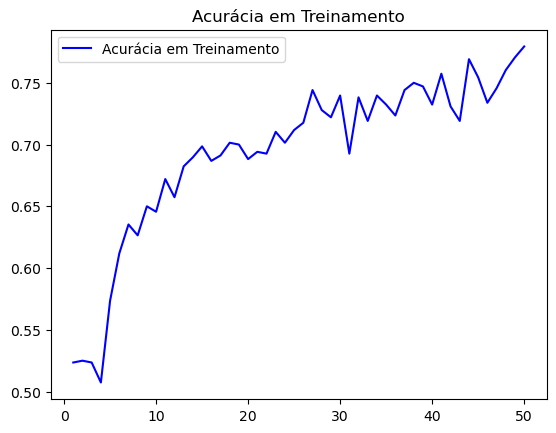

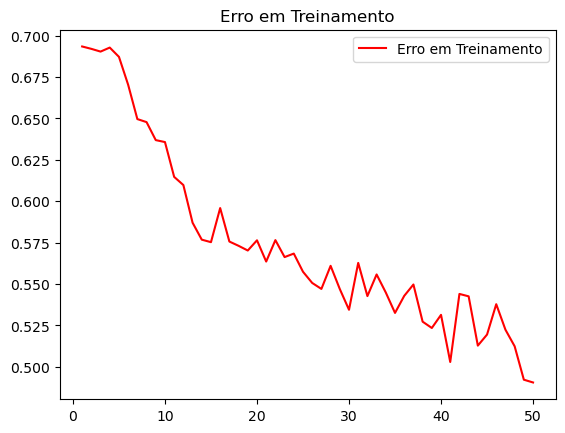

<Figure size 640x480 with 0 Axes>

In [89]:
# Plot

plt.plot(epochs, acc, '-', label = 'Acurácia em Treinamento', color = 'blue')
plt.title('Acurácia em Treinamento')
plt.legend()
plt.figure()

plt.plot(epochs, loss, '-', label = 'Erro em Treinamento', color = 'red')
plt.title('Erro em Treinamento')
plt.legend()
plt.figure()

Os gráficos acima estão com um comportamento não muito estável, isso indica que temos que analisar melhor a taxa de aprendizagem do modelo. O comportamento ideal são curvas mais estavéis. 

<Figure size 640x480 with 0 Axes>

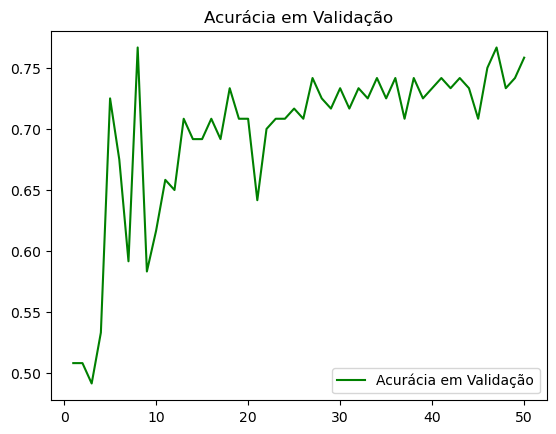

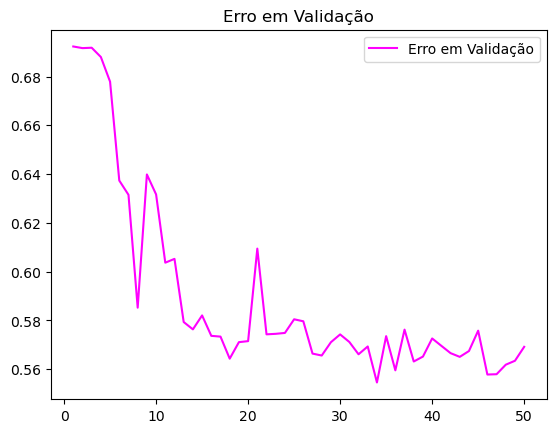

<Figure size 640x480 with 0 Axes>

In [90]:
# Plot

plt.plot(epochs, val_acc, '-', label = 'Acurácia em Validação', color = 'green')
plt.title('Acurácia em Validação')
plt.legend()
plt.figure()

plt.plot(epochs, val_loss, '-', label = 'Erro em Validação', color = 'magenta')
plt.title('Erro em Validação')
plt.legend()
plt.figure()

In [91]:
# Vamos obter os labels dos dados de teste
labels_teste = gen_teste.classes

In [92]:
# Precisamos dos labels para o plot da matriz de confusão
labels_teste.shape

(120,)

In [93]:
# Imprimimos a etiqueta (label) associada a cada classe
gen_teste.class_indices

{'Normal': 0, 'Tuberculose': 1}

In [94]:
# Fazemos as previsões
previsoes = model.predict_generator(gen_teste, steps = passos_val, verbose = 1)

12/12 [==============================] - 1s 39ms/step


In [95]:
# Shape das previsões
previsoes.shape

(120, 2)

In [96]:
# Função para a Matriz de Confusão
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.YlOrRd):

    # Se normalize = True, obtemos a matriz de confusão com dados normalizados
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    # Mostramos a Matriz de Confusão
    print(cm)

    # Plot
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Plot do texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

In [97]:
# A função argmax() retorna o índice do valor máximo em uma linha
matriz_conf = confusion_matrix(labels_teste, previsoes.argmax(axis = 1))

In [98]:
# Labels dos dados de teste
gen_teste.class_indices

{'Normal': 0, 'Tuberculose': 1}

In [99]:
# Definimos os rótulos dos labels da classe. Eles precisam corresponder a ordem mostrada acima.
matriz_conf_plot_labels = ['Normal', 'Tuberculose']

Matriz de Confusão Sem Normalização
[[44 17]
 [11 48]]


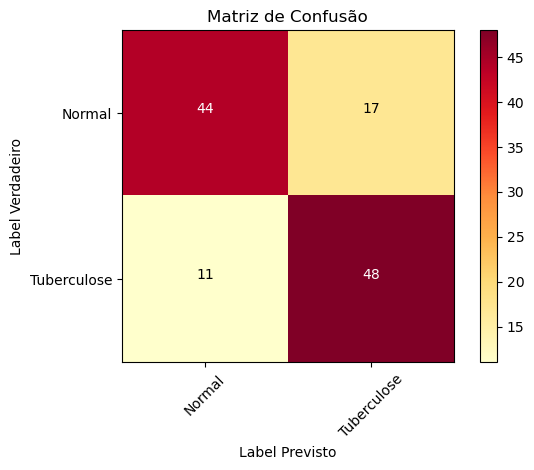

In [100]:
# E então criamos o plot
plot_confusion_matrix(matriz_conf, matriz_conf_plot_labels, title = 'Matriz de Confusão')

In [101]:
# Geramos a sequência na qual o gerador processou as imagens de teste
imagens_teste = gen_teste.filenames

In [102]:
# Obtemos os rótulos verdadeiros
y_true = gen_teste.classes

In [103]:
# Obtemos os rótulos previstos
y_pred = previsoes.argmax(axis=1)

In [104]:
from sklearn.metrics import classification_report

In [105]:
# Gera o relatório de classificação
report = classification_report(y_true, y_pred, target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.80      0.72      0.76        61
 Tuberculose       0.74      0.81      0.77        59

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120



- Recall = Dada uma classe, o classificador será capaz de detectá-la?

- Precision = Dada uma previsão de classe, qual a probabilidade de estar correta?

- F1 Score = A média harmônica de Recall e Precision. Essencialmente, ele pune valores extremos.

F1 Score é maior que 0.8 para a classe Normal, indicando que o modelo tende a prever melhor essa categoria, que a categoria Tuberculose. Podemos voltar e tentar ajustar alguns hiperparâmetros. Vou deixar isso com você.

Mas no geral, modelo apresenta um bom equilíbrio, embora ainda tenhamos espaço para melhorias. Leia o manual em pdf na sequência com o passo a passo para deploy do modelo.